In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from matplotlib import pyplot as plt
import qiskit.providers.aer.noise as noise
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
for backend in provider.backends():
    print(backend)

ibmq_qasm_simulator
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila


In [2]:
from qiskit.extensions import UnitaryGate
sqrtX = UnitaryGate([[1/np.sqrt(2), -1/np.sqrt(2)*1j], [-1/np.sqrt(2)*1j, 1/np.sqrt(2)]], label='X^1/2')
sqrtY = UnitaryGate([[1/np.sqrt(2), -1/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)]], label='Y^1/2')
sqrtW = UnitaryGate([[1/np.sqrt(2), -1/np.sqrt(2)*np.sqrt(1j)], [1/np.sqrt(2)*np.sqrt(-1j), 1/np.sqrt(2)]], label='W^1/2')

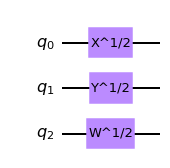

In [3]:
# test that add gate works
qc = QuantumCircuit(3)
qc.draw()
qc.append(sqrtX, [0])
qc.append(sqrtY, [1])
qc.append(sqrtW, [2])
qc.draw()

In [4]:
import random
def random_gate(num_qubits, operands):
    """
    Args:
    - operands - gates to choose from
    Out:
     - Random unitary gate from operands
    """
    choices = random.choices(population = operands, k = num_qubits)
    if len(choices) == 1:
        return choices[0]
    return choices

In [5]:
std_operands = [sqrtX, sqrtY, sqrtW]
rand_gate_test = random_gate(num_qubits = 1, operands= std_operands)
rand_gate_test.to_matrix()

array([[ 0.70710678+0.j, -0.70710678+0.j],
       [ 0.70710678+0.j,  0.70710678+0.j]])

In [6]:
def gen_rqc(num_qubits, depth, operands = std_operands, seed = 2022):
    reg = [i for i in range(num_qubits)]
    random.seed(seed)
    qc = QuantumCircuit(num_qubits)
    qc.h([i for i in range(qc.num_qubits)])
    choices = [None]*num_qubits
    for i in range(depth):
        # cz gate layer
        for j in range(num_qubits):
            choice = random_gate(num_qubits=1, operands = operands)
            while choice == choices[j]:
                choice = random_gate(num_qubits=1, operands = operands)
            choices[j] = choice # store to make sure the same gate does not get chosen two times consequtively
            qc.unitary(choice, [j], label = choice.label)
        # random gate layer
        if i%2 == 0:
            igate = np.arange(0,num_qubits-2, 2)
            for j in igate: 
                qc.cz(j, j+1)
        else:
            igate = np.arange(1,num_qubits-1, 2)
            for j in igate:
                qc.cz(j, j+1)
        qc.barrier()
        # for num in k:
        #     qc.id(num)
                   
    return qc


In [7]:
qc.barrier?

Signature:
qc.barrier(
    *qargs: Union[qiskit.circuit.quantumregister.Qubit, qiskit.circuit.quantumregister.QuantumRegister, int, slice, Sequence[Union[qiskit.circuit.quantumregister.Qubit, int]]],
) -> qiskit.circuit.instructionset.InstructionSet
Docstring:
Apply :class:`~qiskit.circuit.Barrier`. If qargs is empty, applies to all qubits in the
circuit.

Returns:
    qiskit.circuit.InstructionSet: handle to the added instructions.
File:      /opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py
Type:      method


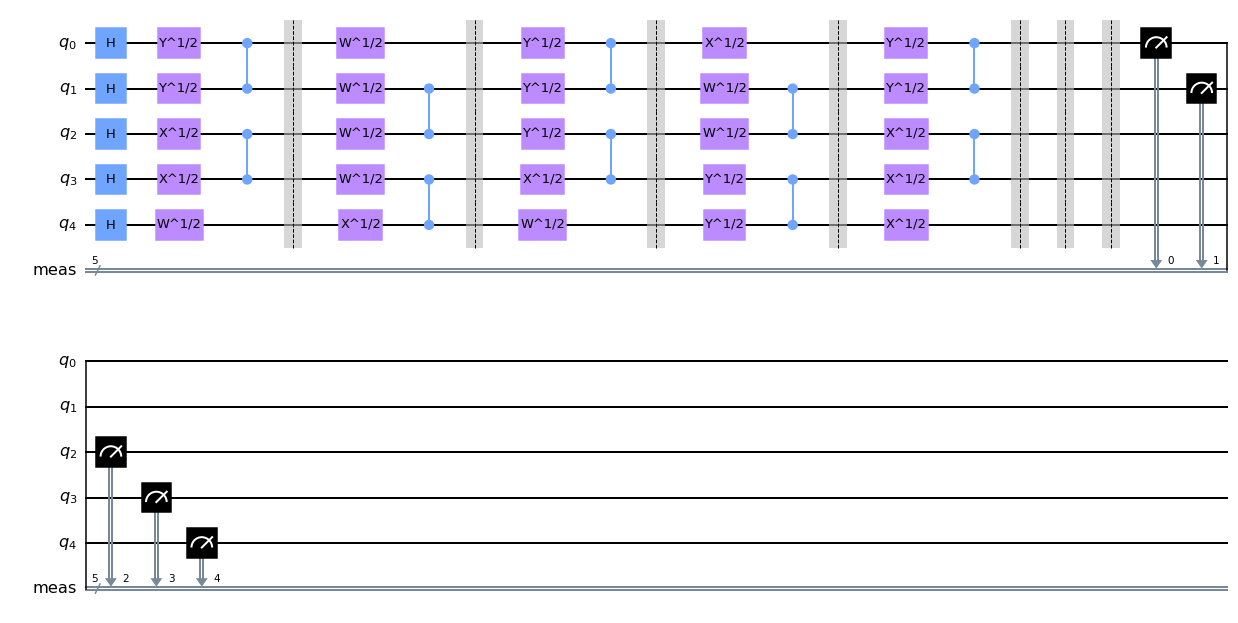

In [8]:
qc5 = gen_rqc(num_qubits=5, depth = 5)
qc5.save_statevector()
qc5.measure_all()
qc5.draw('mpl')

In [9]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
backend = provider.get_backend('ibmq_lima')
backend_noise_model = NoiseModel.from_backend(backend)

#Create the simulators

# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
t_qc5 = transpile(qc5, sim_ideal)

#Design noise model

# Error parameters
p1 = 0.005  # damping parameter for single qubit operations
p2 = 0.01   # damping parameter for two-qubit operations

# Construct the error
# Depolarizing quantum errors
error_1 = noise.depolarizing_error(p1, 1)
error_2 = noise.depolarizing_error(p2, 2)

designed_noise_model = noise.NoiseModel()
designed_noise_model.add_all_qubit_quantum_error(error_1, ['unitary'])
designed_noise_model.add_all_qubit_quantum_error(error_2, ['cz'])

# Create noisy simulator backend and transpile circuit
sim_noise = AerSimulator(noise_model=designed_noise_model)
t_qc5_noisy = transpile(qc5, sim_noise)

qc5.measure_all()

In [10]:
res_noisefree = sim_ideal.run(t_qc5, shots=int(1e5)).result()
state = res_noisefree.get_statevector()
prob_noisefree = state.probabilities()
res_noise = sim_noise.run(t_qc5_noisy, shots=int(1e5)).result()


In [11]:
import qiskit.quantum_info
def prob_getcounts(result, Nshots, qc = None):
    totcount = 0
    x = result.get_counts()
    for state, count in result.get_counts().items():
        x[state] = count/Nshots
        #x.append(StateVector(state))
    return x
# check sum of prob equals 1
p_noisefree = prob_getcounts(result = res_noisefree, Nshots = int(1e4))
p_noisy = prob_getcounts(result = res_noise, Nshots = int(1e4))
# p_noisefree

In [12]:
def compute_entropy(probs):
    # print("\n entropy function probs: ", probs)
    return - np.sum(probs*np.log(probs))

# calculate the cross entropy estimate
def cross_entropy(probdict_noisy, probdict_noisefree, num_qubits, euler_const = 0.577):
    #calculate the estimate of the fidelity aka cross entropy difference
    N = 2**(num_qubits)
    H0 = np.log(N) + euler_const
    pA = np.array( list( probdict_noisy.values() ) )
    pU = np.array( list( probdict_noisefree.values() ) )
    H_pA_pU = np.sum( ( (1/N) - pA )*np.log( 1 / pU ) )
    alpha = H0 - H_pA_pU
    return alpha, H_pA_pU
# cross_entropy(probdict_noisy = p_noisy, probdict_noisefree = p_noisefree)

# calculate the cross entropy difference estimate
def cross_entropy_est(probdict_noisy, pU, num_qubits, euler_const = 0.577):
    #calculate the estimate of the fidelity aka cross entropy difference
    H0 = np.log(2**(num_qubits)) + euler_const
    H_pA_pU = 0
    nshots = sum(list(probdict_noisy.values() ))
    norm = 0
    for key, value in probdict_noisy.items():
        ind = int(key.split(" ")[0], 2) # indices of the bitstrings, have to split between qubits and classical bits
        norm += value
        H_pA_pU += -value*np.log( pU[ind] )
    # print(value)
    if norm > 1:
        H_pA_pU /= norm
    # print("norm", norm)
    alpha_CLT = H0 - H_pA_pU
    return alpha_CLT, H_pA_pU
print(prob_noisefree)
cross_entropy_est(probdict_noisy = p_noisy, pU = prob_noisefree, num_qubits=5)

[0.01146742 0.01272406 0.02587891 0.02229339 0.07660266 0.07644948
 0.01105101 0.01353307 0.04840925 0.08749803 0.01675474 0.03563016
 0.00738171 0.00167552 0.0524543  0.0001963  0.03214279 0.02700865
 0.00788437 0.06916839 0.05269125 0.00881781 0.03228159 0.02000516
 0.02220961 0.00424135 0.07420438 0.02000516 0.01661594 0.0315851
 0.01197008 0.06916839]


(0.8261698504742392, 3.2165660523254878)

In [13]:
# calculate the cross entropy difference estimate
def compute_IPRK(probdict_noisfree, pU, num_qubits, k, euler_const = 0.577):
    iprk = 0
    for key, value in probdict_noisfree.items():
        ind = int(key.split(" ")[0], 2) # indices of the bitstrings, have to split between qubits and classical bits
        iprk += np.abs(value* pU[ind] )**(2*k)
    return iprk
compute_IPRK(probdict_noisfree = p_noisy, pU = prob_noisefree, k = 2, num_qubits=5)

6.359059213763423e-05

In [14]:
import pandas as pd
ks = np.arange(2,11,2)
df_qs = pd.DataFrame(columns= ['ninstance', 'num_qubits', 'depth', 'pU','entropy','cross_entropy', 'cross_entropy_diff','nshots']+['IPR%i'%k for k in ks])
df_qs

,ninstance,num_qubits,depth,pU,entropy,cross_entropy,cross_entropy_diff,nshots,IPR2,IPR4,IPR6,IPR8,IPR10


In [15]:
# make list of entropy depth pairs
def entropy_vs_depth(df = df_qs, r = 0.0005, num_qubits = 15, depth_range = np.arange(20,30,2), Nshots = int(1e4), ninstance = None, ks = None, plot_hist_NpU = False):
    N = 2**(num_qubits)
    
    # get backend and noise model for simulating real hardware
    # backend = provider.get_backend('ibmq_lima')
    # noise_model = NoiseModel.from_backend(backend)
    
    for i in range(len(depth_range)):
        depth = depth_range[i]
        # generate the quantu, circuit
        qc = gen_rqc(num_qubits=num_qubits, depth = depth)
        qc.save_statevector()
        
        # Create ideal simulator backend and transpile circuit
        sim_ideal = AerSimulator(method='statevector')
        # t_qc = transpile(qc, sim_ideal)
        
        #Design noise model

        # Error parameters
        rinit = r # error rate for initialisation of the qrc
        r1 = r/10 # gate 1 error rate
        r2 = r # gate 2 error rate
        g1 = depth # number of single qbit gates
        g2 = depth # number of 2-qbit gates
        rmes = r # error rate for measurements
        p1 = r1/3 # prob of applying the error after each single-qubit gate
        p2 = r2/15 # prob of applying the error after each two-qubit gate
        
        # initialise the noise model
        designed_noise_model = noise.NoiseModel()
        # Construct the error
        bit_flip = noise.pauli_error([('X', r), ('I', 1 - r)]) # construct bit-flip error
        
        # Depolarizing quantum errors
        error_1 = noise.depolarizing_error(p1, 1)
        error_2 = noise.depolarizing_error(p2, 2)
        
        designed_noise_model.add_all_qubit_quantum_error(bit_flip, "reset")
        designed_noise_model.add_all_qubit_quantum_error(error_1, ['unitary'])
        designed_noise_model.add_all_qubit_quantum_error(error_2, ['cz'])
        designed_noise_model.add_all_qubit_quantum_error(bit_flip, "measure")

        # Create noisy simulator backend and transpile circuit
        sim_noise = AerSimulator(noise_model=designed_noise_model)
        # t_qc_noisy = transpile(qc, sim_noise)
        
        # measure all qubits
        qc.measure_all()
        
        # get probabilites from ideal circuit
        result_ideal = sim_ideal.run(qc, shots=Nshots).result()
        state = result_ideal.get_statevector()
        # print(state.probabilities())
        pU = state.probabilities()
        # print(probs_ideal)
        
        # get noisy probabilites
        result_noisy = sim_noise.run(qc, shots=Nshots).result()
        probs_noisy = list(result_noisy.get_counts(0).values())
        # print(probs_noisy)
        
        #compute entropy
        entropy = compute_entropy(probs = np.array(pU))
        
        #compute cross entropy and cross entropy difference
        # print(result_noisy.get_counts(qc))
        crentropy_diff, crentropy = cross_entropy_est(probdict_noisy = result_ideal.get_counts(0), pU = pU, num_qubits=num_qubits)
        
        # compute iprk
        IPR_k = [compute_IPRK(probdict_noisfree = result_noisy.get_counts(qc), pU = pU, k = k, num_qubits=num_qubits) for k in ks]
        
        #append to output        
        print([float(IPR_k[ik]) for ik in range(len(ks))])
        tempdf = pd.DataFrame([[ninstance, num_qubits, depth, tuple(pU), r, 
                               entropy, crentropy, crentropy_diff, Nshots] + [IPR_k[ik] for ik in range(len(ks))]], 
                           columns= ['ninstance', 'num_qubits', 'depth', 'pU', 'r',
                                     'entropy','cross_entropy', 'cross_entropy_diff','nshots']+ ['IPR%i'%k for k in ks])
        df = pd.concat([df, tempdf])
    return df

In [16]:
dfmaster = pd.DataFrame(columns= ['ninstance', 'num_qubits', 'depth', 'pU','entropy','cross_entropy', 'cross_entropy_diff','nshots']+['IPR%i'%k for k in ks])
dfmaster

,ninstance,num_qubits,depth,pU,entropy,cross_entropy,cross_entropy_diff,nshots,IPR2,IPR4,IPR6,IPR8,IPR10


In [ ]:
[2.277032877344497e-11, 1.1755045499310592e-23, 1.2059734918635983e-35, 1.3926227998354163e-47, 1.6868402271641903e-59]
[7.672438001712596e-11, 8.565465383663453e-22, 1.8993120639828826e-32, 4.701468505362647e-43, 1.2019776400611612e-53]
[5.071877983184607e-11, 1.6316105178655472e-22, 9.033039406838836e-34, 5.6045177986890074e-45, 3.6580695645169923e-56]
[2.0826122489189738e-10, 2.4133384570823265e-20, 3.701264324775247e-30, 5.721767676948536e-40, 8.849061367482024e-50]
[5.448121159628619e-11, 1.4931140214502132e-22, 7.586650191980494e-34, 4.5168330367511675e-45, 2.9117434277524474e-56]
[1.0304117133008804e-10, 3.1538495812353963e-21, 1.622259877722394e-31, 8.714105844518793e-42, 4.719368452138298e-52]
[8.055002047900365e-11, 2.767912941683796e-21, 1.4427246087667112e-31, 7.565008725234365e-42, 3.967420947703589e-52]
[5.491048445237714e-11, 1.7956743305662727e-22, 1.1669529975012596e-33, 8.647077550564739e-45, 6.68292903772565e-56]
[5.8035512788838246e-11, 2.9851073067768206e-22, 2.8185478243174204e-33, 2.9530133769127063e-44, 3.1993184864754387e-55]
[3.37154015212217e-11, 5.2004225068156617e-23, 1.8969475557974913e-34, 8.22842328829929e-46, 3.7924980103555794e-57]
[3.111063539156623e-11, 3.1570553205533093e-23, 7.17146439303078e-35, 1.9975864101645144e-46, 6.0080628706952614e-58]
[7.073495458100128e-11, 7.786556825328159e-22, 1.7374703628924387e-32, 4.302335159566539e-43, 1.0897481941382306e-53]
[5.758586868613874e-11, 4.554750788827905e-22, 6.440876812246212e-33, 9.477976885552224e-44, 1.4038917287973936e-54]
[3.933820538576763e-11, 7.987547362912083e-23, 3.6626314022127676e-34, 2.020244713982955e-45, 1.1934449004725355e-56]
[6.148610301347959e-11, 1.6291968168202963e-22, 8.511967257717543e-34, 5.3525288961181674e-45, 3.6126284606416702e-56]
[3.07550066804414e-11, 3.8033632259403213e-23, 1.2700360849675891e-34, 5.416514878115809e-46, 2.480941518595163e-57]
[4.934122880429932e-11, 8.462812227524398e-23, 2.384315579665616e-34, 7.371431423380934e-46, 2.357579915641741e-57]
[8.175295196533245e-11, 2.769226130514305e-21, 1.4427435794089403e-31, 7.565017846290663e-42, 3.967421338274179e-52]
[3.298621566904121e-11, 4.081223643566368e-23, 1.0263486084254563e-34, 3.061886148503098e-46, 9.741263362644908e-58]
[5.824954671548351e-11, 3.3532194686528343e-22, 4.1117207689309024e-33, 5.912730559406942e-44, 8.919146872593682e-55]
[4.0570650446405294e-11, 6.231340181004659e-23, 2.0701068842312247e-34, 8.1872042486675e-46, 3.434210677109859e-57]
[1.0491178703713928e-10, 1.5644377734876852e-21, 4.195365413573877e-32, 1.2732572006848497e-42, 4.051240036083925e-53]
[2.5878639493567012e-11, 2.1031341124002338e-23, 4.3654967390783846e-35, 1.140306464976588e-46, 3.265793146743206e-58]
[6.45384712020826e-11, 5.310792157841926e-22, 7.468651473557739e-33, 1.1273887043623775e-43, 1.7464957047754785e-54]
[4.8748950150567087e-11, 1.6239354203875734e-22, 1.2367876018187666e-33, 1.1423195450407423e-44, 1.121788700412229e-55]
[9.024646819650645e-11, 1.3228249812351371e-21, 4.1555257064213834e-32, 1.4098187645677889e-42, 4.839927741642571e-53]
[4.934174780452203e-11, 4.0608320041041387e-22, 7.319555359198078e-33, 1.401411325816086e-43, 2.7050100904008385e-54]
[4.7931791829642395e-11, 1.7864922243142335e-22, 1.7402596507486286e-33, 1.9743380711200348e-44, 2.309284022274328e-55]
[7.715497280676963e-11, 1.1043976129564705e-21, 2.6692063928451057e-32, 7.01351958391523e-43, 1.908093854214636e-53]
[2.70214815120765e-11, 2.5280293870020326e-23, 7.374629006970155e-35, 2.7613847225766822e-46, 1.0954905365169607e-57]
[8.840271298378654e-11, 2.607952944978336e-21, 1.30447976618429e-31, 6.611802031526899e-42, 3.352668670923144e-52]
[3.2137058104213486e-11, 4.2537348105356685e-23, 1.494278290244402e-34, 6.6922070291524396e-46, 3.2254181182229126e-57]
[3.7786503045979865e-11, 1.1044693650630503e-22, 8.807468467775986e-34, 7.9859432936084e-45, 7.431121026836978e-56]
[2.9726646048019695e-11, 3.476774279003487e-23, 8.397451118112458e-35, 2.2240350057365752e-46, 6.0295138730288315e-58]
[3.164160681130319e-11, 5.116114625213606e-23, 2.1427378041199356e-34, 1.0395129056959888e-45, 5.320302429245666e-57]
[4.6305026668483696e-11, 1.438385612310708e-22, 8.644752788807539e-34, 5.754435116244502e-45, 4.021052536142673e-56]
[5.129254361009586e-11, 2.3833128643680443e-22, 3.218804347007524e-33, 4.713887283054422e-44, 6.941688217263797e-55]
[5.6236566883077516e-11, 2.0805704533066173e-22, 1.6170474384093873e-33, 1.4825043291885774e-44, 1.4382668030369394e-55]
[4.282304720102767e-11, 1.1319762787375724e-22, 6.055867564042101e-34, 3.705364505564156e-45, 2.388562303672774e-56]
[5.860511966886813e-11, 2.264701985556438e-22, 1.8474064376516958e-33, 1.8590748629029183e-44, 2.026854312629682e-55]
[4.621662340812567e-11, 1.5443587835862565e-22, 9.545862865570903e-34, 6.415575103088302e-45, 4.449714536082521e-56]
[5.3179625275912414e-11, 6.149189718885564e-22, 1.4644475183715446e-32, 3.5764431498374227e-43, 8.745169008606774e-54]
[4.3923873407614917e-11, 8.854049404955788e-23, 3.878689575214201e-34, 2.103744077619363e-45, 1.2469570099110082e-56]
[5.1193809024243476e-11, 4.745522365233417e-22, 9.385529925988661e-33, 1.9601865497005795e-43, 4.1190839328632466e-54]
[3.738371813211184e-11, 7.780054094633571e-23, 4.509726151497569e-34, 3.2017339125741565e-45, 2.3713351040887335e-56]
[4.742142183092042e-11, 8.142768805948925e-23, 2.8453992845210283e-34, 1.2856960570915696e-45, 6.571312730995524e-57]
[3.307741207719e-11, 1.1106524468379221e-22, 1.019237972276654e-33, 1.0132917752031785e-44, 1.0152535407612638e-55]
[5.117246367412846e-11, 1.1660833542731207e-22, 4.95531504101246e-34, 2.459763996205288e-45, 1.3104669555537936e-56]
[4.184272472159243e-11, 2.181215691104887e-22, 2.129202948153152e-33, 2.1781304161492839e-44, 2.253483458614968e-55]
[4.932987844323886e-11, 2.0618705664607274e-22, 2.173728942205836e-33, 2.676413668149047e-44, 3.390693668428843e-55]
[5.3989452482267086e-11, 8.2409833487084585e-22, 2.2736210373679693e-32, 6.4231798020199524e-43, 1.8179483977751579e-53]
[3.595454576835151e-11, 8.638312916800002e-23, 5.887645048478951e-34, 4.7342182086016725e-45, 3.902502098100597e-56]
[3.528134802353063e-11, 1.1421528808214116e-22, 1.0215748206922778e-33, 1.009031927798159e-44, 1.008632109970166e-55]
[4.2583948172059404e-11, 1.2037361538522403e-22, 7.143339213278795e-34, 4.811216822658336e-45, 3.4249200368089474e-56]
[5.985364488533791e-11, 1.9963552344767348e-22, 1.2645446047636714e-33, 9.204001372183064e-45, 7.088544683227567e-56]
[5.812789662377085e-11, 3.733250388867531e-22, 4.6306653621028064e-33, 6.200977727629766e-44, 8.52643765342439e-55]
[3.9558432320055776e-11, 6.048950721766561e-23, 1.944715830350196e-34, 7.562904778118508e-46, 3.207601928331658e-57]
[2.347055338773311e-11, 9.533215559727975e-24, 8.425686446653304e-36, 9.108140512869214e-48, 1.0587356349188779e-59]
[4.8863817722357907e-11, 1.6383809052564065e-22, 1.4034983185880038e-33, 1.4399522344455082e-44, 1.5430610724972455e-55]
[4.8254470966194134e-11, 2.761654181971813e-22, 3.534984670093156e-33, 5.108726396858938e-44, 7.58371519674345e-55]
[7.392246319677839e-11, 6.659733531428978e-22, 1.374765211137797e-32, 3.1556193199496487e-43, 7.404667877476874e-54]
[4.341352234919223e-11, 5.167773317617715e-22, 1.1465624742476315e-32, 2.5830430658655833e-43, 5.822982592428132e-54]
[2.7224441939794056e-11, 3.520625429879764e-23, 1.0367588053435715e-34, 3.526040491498631e-46, 1.2656924124479864e-57]
[4.975450832109215e-11, 6.130322702787097e-22, 1.4644786517989835e-32, 3.576491157709583e-43, 8.745184442906005e-54]
[4.019424490057705e-11, 1.098060242736369e-22, 7.057188090121109e-34, 5.1773627167513643e-45, 3.953399561406488e-56]
[4.474635858815225e-11, 4.632856612588838e-22, 9.362437563848094e-33, 1.959582247627608e-43, 4.118888502809145e-54]
[3.2169229666449524e-11, 2.2912205125384658e-23, 3.1889338886772995e-35, 5.365566644394381e-47, 9.88124584278105e-59]
[3.860780324991984e-11, 1.016838514710533e-22, 6.097411139145002e-34, 3.9970809300283203e-45, 2.6591329272895655e-56]
[2.8053997827200875e-11, 1.8792267097082305e-23, 2.718512714369814e-35, 4.849881947884328e-47, 9.319011399288461e-59]
[3.573611734053236e-11, 4.587771532615068e-23, 1.4133496110553061e-34, 5.57999597834652e-46, 2.411072683426338e-57]
[3.4791040873793497e-11, 5.458003366874228e-23, 1.663473428720822e-34, 5.6417895971600804e-46, 1.99783712071462e-57]
[6.279067165904083e-11, 3.880941051184012e-22, 5.2385803930122874e-33, 8.32282600437418e-44, 1.379875967998122e-54]
[5.249595937239261e-11, 2.5874198191166398e-22, 2.83898281861023e-33, 3.606981832402374e-44, 4.797612618221391e-55]
[3.632712797684387e-11, 5.89533740734627e-23, 2.132905673120974e-34, 9.02509105744852e-46, 4.066586462172706e-57]
[7.638022777749064e-11, 5.313472445040824e-22, 7.166119923886238e-33, 1.1369195535673431e-43, 1.923850301720049e-54]
[2.675419566725659e-11, 1.1478016393025016e-23, 1.0640372698758973e-35, 1.2489723647689752e-47, 1.6159681952416343e-59]
[4.964069915115805e-11, 4.728060930119658e-22, 9.397099683435795e-33, 1.9612497806937324e-43, 4.119705144008949e-54]
[2.5473396365248058e-11, 1.1142831523073664e-23, 9.763920184194053e-36, 1.0639736469172569e-47, 1.2856242926803047e-59]
[4.5827085770677503e-11, 1.8346047247588756e-22, 1.9172910674801822e-33, 2.281414926187372e-44, 2.780242925134151e-55]
[1.1144654047087733e-10, 6.222649497274731e-21, 4.853209862617895e-31, 3.8122216214889257e-41, 2.9954592984575944e-51]
[9.104382584273132e-11, 1.2789650842932437e-21, 3.383249134757077e-32, 9.621430776235913e-43, 2.818978606933721e-53]
[1.2632130348494773e-10, 4.017664782898249e-21, 2.3017740557036064e-31, 1.3965434237739123e-41, 8.527197848360132e-52]
[4.7365010513585827e-11, 8.627873603331212e-23, 3.0491390458374747e-34, 1.2363026766664366e-45, 5.340084129478808e-57]
[4.7562490988942946e-11, 2.07360356842832e-22, 2.3684651939475576e-33, 3.0631015565253945e-44, 4.033283616614659e-55]
[4.811415545145679e-11, 3.2948380134852947e-22, 4.94569211184355e-33, 8.095612480070764e-44, 1.3508889999326382e-54]
[4.790157889819549e-11, 1.5751555128492339e-22, 1.1896046634700818e-33, 1.0785049200663273e-44, 1.0383339693411828e-55]
[3.273242343568321e-11, 3.940013864067887e-23, 9.871239063182014e-35, 2.908140358717666e-46, 9.100602962732473e-58]
[6.759437072680637e-11, 1.1486131499167607e-21, 3.6334773349065317e-32, 1.1918973927178498e-42, 3.9313259635085964e-53]
[5.5548079492313745e-11, 4.181512478813366e-22, 6.066067048905033e-33, 9.35750830028826e-44, 1.4808043254042225e-54]
[3.2868609434798465e-11, 7.049969949739978e-23, 3.2844361837297564e-34, 1.6938033722602356e-45, 8.9634247664611e-57]
[2.9423439450781886e-11, 2.780557281355739e-23, 7.222379138873706e-35, 2.4297843363280265e-46, 8.841712131958636e-58]
[7.219351709919041e-11, 9.501509613144543e-22, 2.624817115764892e-32, 7.707821260059373e-43, 2.280148675892673e-53]
[4.586294152556176e-11, 2.5654495436374643e-22, 3.446542549105625e-33, 5.06806357721673e-44, 7.564386349741479e-55]
[3.308406930806618e-11, 4.5004393856121527e-23, 1.9370427979746645e-34, 1.0458867698992053e-45, 5.875050547596175e-57]
[2.3409151373310964e-11, 1.1163359467719041e-23, 1.237166015546906e-35, 1.6675214671894707e-47, 2.4114134743222345e-59]
[9.766592266158523e-11, 3.1408174835400266e-21, 1.5532413887395823e-31, 8.072022687799495e-42, 4.259520778095802e-52]
[3.7146781094736535e-11, 4.93933432883107e-23, 1.6470814565229044e-34, 6.9628078659375016e-46, 3.172416419700073e-57]
[2.8152968249982054e-11, 1.7758264928931015e-23, 2.55148471500703e-35, 4.445579266905738e-47, 8.297148952575357e-59]
[4.7781593418226645e-11, 1.3411023567288041e-22, 8.201730851840427e-34, 6.123500443682224e-45, 4.946085623190437e-56]
[3.583686193181701e-11, 5.044750396633111e-23, 1.6961060345422272e-34, 6.773478495306842e-46, 2.826755172975064e-57]
[4.2568680708798164e-11, 8.152404520990691e-23, 3.220729021633099e-34, 1.504369718655833e-45, 7.483077920139165e-57]
[2.7063038094064217e-11, 1.9417448692162904e-23, 3.992427105523052e-35, 1.1054763995894407e-46, 3.355595565413674e-58]
[1.4884723670766262e-10, 9.656921295281056e-21, 9.054463797382935e-31, 8.700249369204363e-41, 8.393200314895509e-51]
[4.7332300497543926e-11, 1.4665651478032083e-22, 1.01698688715564e-33, 8.442673584028177e-45, 7.463018129585061e-56]
[4.0875672444233026e-11, 6.962181128857733e-23, 2.5473030615654525e-34, 1.0897719410406083e-45, 4.932248982049696e-57]
[3.2436016702275824e-11, 4.3985978604451176e-23, 1.229408396925044e-34, 3.952845253795038e-46, 1.3505937729271004e-57]
[3.2564467432059765e-11, 2.9327206466818265e-23, 5.765863099921924e-35, 1.3639503877707153e-46, 3.4134082721409866e-58]
[5.312041313616396e-11, 2.062640728245415e-22, 1.706108456236246e-33, 1.5729048441328018e-44, 1.4877115633595706e-55]
[3.9992364074369046e-11, 8.228031531955757e-23, 4.458619280597842e-34, 3.004292191580669e-45, 2.1474306028663095e-56]
[3.4588347953245874e-11, 3.6858470621101714e-23, 9.885002994609964e-35, 3.441512185345934e-46, 1.3233506413274854e-57]

In [ ]:
depth_range = np.arange(20,41,2)
rs = np.array([0, 0.0005, 0.001, 0.002, 0.005])
Ninstances = 10
shape = rs.shape + (Ninstances,) + depth_range.shape
depth5, cross_entropy5, cross_entropy_diff5, IPRK5, entropy5 = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(rs.shape + (Ninstances,)+ ks.shape +depth_range.shape), np.zeros(shape)

for j in range(len(rs)):
    r = rs[j]
    for i in range(Ninstances):
        df_qs = entropy_vs_depth(r = r, depth_range = depth_range, ks=ks, ninstance = i)
        dfmaster = pd.concat([dfmaster, df_qs])

[2.277032877344497e-11, 1.1755045499310592e-23, 1.2059734918635983e-35, 1.3926227998354163e-47, 1.6868402271641903e-59]
[7.672438001712596e-11, 8.565465383663453e-22, 1.8993120639828826e-32, 4.701468505362647e-43, 1.2019776400611612e-53]
[5.071877983184607e-11, 1.6316105178655472e-22, 9.033039406838836e-34, 5.6045177986890074e-45, 3.6580695645169923e-56]
[2.0826122489189738e-10, 2.4133384570823265e-20, 3.701264324775247e-30, 5.721767676948536e-40, 8.849061367482024e-50]
[5.448121159628619e-11, 1.4931140214502132e-22, 7.586650191980494e-34, 4.5168330367511675e-45, 2.9117434277524474e-56]
[1.0304117133008804e-10, 3.1538495812353963e-21, 1.622259877722394e-31, 8.714105844518793e-42, 4.719368452138298e-52]
[8.055002047900365e-11, 2.767912941683796e-21, 1.4427246087667112e-31, 7.565008725234365e-42, 3.967420947703589e-52]
[5.491048445237714e-11, 1.7956743305662727e-22, 1.1669529975012596e-33, 8.647077550564739e-45, 6.68292903772565e-56]
[5.8035512788838246e-11, 2.9851073067768206e-22, 2.818

In [23]:
def compute_yaxis_iprk(iprk):
    # for such a large number it is more convenient to use the logarithm
    lognumber = 15*9*np.log(2)/sum([np.log(i) for i in range(1,11)])
    return np.exp(lognumber)

490.3899222666713

In [ ]:
dfmaster

In [20]:
def paperplots(depth, iprk, ce, ced, e):
    print(iprk.shape)
    plt.figure()
    for i in range(len(iprk)):
        plt.plot(depth, iprk[i]*(2**(5))**(i+1)/np.math.factorial(i+2), '-o', label = '$k = %i$'%(i+2)) # *2**(5)**(i+2)/np.math.factorial(i+2) - get too large number
        plt.yscale('log')
        plt.xlabel("Depth")
        plt.ylabel("$IPRK^{(k)} N^{k-1}/k!$")
    plt.legend(loc='best')

    plt.figure()
    plt.plot(depth, ce, '-ok')
    plt.xlabel("Depth")
    plt.ylabel("Mean cross-entropy")

    plt.figure()
    plt.plot(depth, ced, '-ok')
    plt.xlabel("Depth")
    plt.ylabel("Fidelity")
    
    plt.figure()
    plt.plot(depth, e, '-ok')
    plt.xlabel("Depth")
    plt.ylabel("Mean entropy")

(10, 5, 11)
Traceback (most recent call last):
  File "/tmp/ipykernel_788/1498824343.py", line 1, in <module>
    paperplots(depth = depth5[0,0], iprk = np.mean(IPRK5, axis=0), ce = np.mean(cross_entropy5, axis=0), ced=np.mean(cross_entropy_diff5, axis=0), e = np.mean(entropy5, axis=0))
  File "/tmp/ipykernel_788/1130507269.py", line 5, in paperplots
    plt.plot(depth, iprk[i]*(2**(5))**(i+1)/np.math.factorial(i+2), '-o', label = '$k = %i$'%(i+2)) # *2**(5)**(i+2)/np.math.factorial(i+2) - get too large number
  File "/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py", line 2757, in plot
    return gca().plot(
  File "/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1632, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 312, in __call__
    yield from self._plot_args(this, kwargs)
  File "/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 

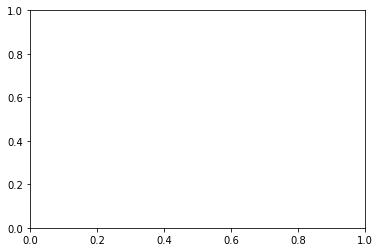

In [21]:
paperplots(depth = depth5[0,0], iprk = np.mean(IPRK5, axis=0), ce = np.mean(cross_entropy5, axis=0), ced=np.mean(cross_entropy_diff5, axis=0), e = np.mean(entropy5, axis=0))

In [ ]:
def add_error(atqubit,atdepth, ondepth, onqubit):
    return (atqubit == onqubit) & (atdepth == ondepth)

def gen_rqc_single_error(num_qubits, depth, errortype = 'x', add_error = add_error, atqubit = False, atdepth = False, operands = std_operands, seed = 2022):
    reg = [i for i in range(num_qubits)]
    random.seed(seed)
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h([i for i in range(qc.num_qubits)])
    choices = [None]*num_qubits
    for i in range(depth):
        # single-qubit gate layer
        for j in range(num_qubits):
            # print(i,j,add_error(atqubit = atqubit,atdepth = atdepth, ondepth = i, onqubit =j))
            choice = random_gate(num_qubits=1, operands = operands)
            while choice == choices[j]:
                choice = random_gate(num_qubits=1, operands = operands)
            choices[j] = choice # store to make sure the same gate does not get chosen two times consequtively
            qc.unitary(choice, [j], label = choice.label)
            if add_error(atqubit = atqubit,atdepth = atdepth, ondepth = i, onqubit =j):
                if errortype == 'x':
                    qc.x(atqubit)
                if errortype == 'z':
                    qc.z(atqubit)
                
        # 2-qubit gate layer
        if i%2 == 0:
            igate = np.arange(0,num_qubits-2, 2)
            for j in igate: 
                qc.cz(j, j+1)
        else:
            igate = np.arange(1,num_qubits-1, 2)
            for j in igate:
                qc.cz(j, j+1)
        qc.barrier()
                   
    return qc


In [ ]:
qrc3 = gen_rqc_single_error(num_qubits=3, depth = 3, atdepth=2, atqubit=2, errortype='z')
qrc3.draw()

In [ ]:
from itertools import product
def fig3(num_qubits, depth, Nshots = 1, errortype = 'x'):
    
    qc_ideal = gen_rqc(num_qubits=num_qubits, depth = depth)
    qc_ideal.save_statevector()
    
    # get probabilites from ideal circuit
    
    # Create ideal simulator backend and transpile circuit
    sim_ideal = AerSimulator()
    t_qc = transpile(qc_ideal, sim_ideal)
    result_ideal = sim_ideal.run(t_qc, shots=Nshots).result()
    state_ideal = result_ideal.get_statevector()
    pideal = state_ideal.probabilities()

    perror = np.zeros((num_qubits, depth, 2**num_qubits))
    for atqubit in np.arange(0,num_qubits,1):
        for atdepth in np.arange(0,depth, 1):
            # print(atqubit, atdepth)
            qc = gen_rqc_single_error(num_qubits=num_qubits, depth = depth, errortype = errortype, atdepth=atdepth, atqubit=atqubit)
            qc.save_statevector()
            
            
            t_qc_paulierror = transpile(qc, sim_ideal)
            
            
            
            # get probabilites from circuit with the one pauli error
            result_paulierror = sim_ideal.run(t_qc_paulierror, shots=Nshots).result()
            state_error = result_paulierror.get_statevector()
            perror[atqubit,atdepth] += state_error.probabilities()
        
    # sorting
    # print(pideal.shape)
    # print(np.mean(perror, axis=0).shape)
    # print(np.mean(np.mean(perror, axis=0), axis=0))
    psorted = [pipe for pipe in zip(*sorted(zip(list(pideal), list(np.mean(np.mean(perror, axis=0), axis=0)))))]
    
    return psorted

In [ ]:
psortx = fig3(10,10)

In [ ]:
psortz = fig3(10,10, errortype='z')

In [ ]:
plt.title("Used Z-gate for Pauli error")
plt.plot(np.arange(0,len(psortz[0]), 1), list(psortz[0]), label='No errors')
plt.plot(np.arange(0,len(psortz[0]), 1), list(psortz[1]), label='One Pauli error(averaged)')
plt.xlabel('Bit-string index $j (p(x_j)$-ordered)')
plt.ylabel('$Np$')
plt.legend(loc='best')